http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader

In [2]:
badBomDF = spark.read.csv('data/nsw_temp.csv', inferSchema='True', header=True)

In [3]:
badBomDF.printSchema()

root
 |-- Product code: string (nullable = true)
 |-- Bureau of Meteorology station number: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Maximum temperature (Degree C): double (nullable = true)
 |-- Days of accumulation of maximum temperature: integer (nullable = true)
 |-- Quality: string (nullable = true)



In [4]:
#badBomDF.groupBy().avg('Maximum temperature (Degree C)')

In [5]:
%%sh

head -n 5 data/nsw_temp.csv

grep "Maximum temperature" data/nsw_temp.csv | wc -l

Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
IDCJAC0010,061087,1965,01,01,25.6,,Y
IDCJAC0010,061087,1965,01,02,32.2,1,Y
IDCJAC0010,061087,1965,01,03,23.1,1,Y
IDCJAC0010,061087,1965,01,04,25.6,1,Y
      41


In [6]:
%%sh

rm -rf 'output/nsw_temp.csv'

In [7]:
sc.textFile('data/nsw_temp.csv').filter(lambda l:l.startswith('IDC')).saveAsTextFile('output/nsw_temp.csv')

In [8]:
bomDF = spark.createDataFrame(spark.read.csv('output/nsw_temp.csv', inferSchema='True', header=False).rdd, 
        schema = ['product_id', 'station_id', 'year', 'month', 'day', 'max_temp', 'days_of_acc', 'quality'])
bomDF.cache()

bomDF.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- station_id: long (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- day: long (nullable = true)
 |-- max_temp: double (nullable = true)
 |-- days_of_acc: long (nullable = true)
 |-- quality: string (nullable = true)



In [9]:
bomDF.groupBy().avg('max_temp')

,avg(max_temp)
0,22.812952


In [10]:
bomDF.select('year').distinct().count()

155

In [11]:
bomDF.groupBy('year').count().sort('year')

,year,count
0,1859,365
1,1860,366
2,1861,365
3,1862,365
4,1863,365
5,1864,366
6,1865,365
7,1866,365
8,1867,365
9,1868,366


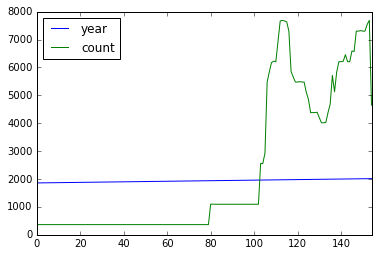

In [12]:
bomDF.groupBy('year').count().sort('year').toPandas().plot()

In [13]:
from pyspark.sql.functions import *
bomDF.groupBy('station_id').count().sort(desc('count')).limit(1)

,station_id,count
0,66062,56470


In [14]:
bomDF.where(col('station_id') == 66062).groupBy('year') \
    .agg(avg('max_temp').alias('avg_max_temp'), stddev('max_temp').alias('sd_max_temp')).sort('year')

,year,avg_max_temp,sd_max_temp
0,1859,21.399452,4.969578
1,1860,20.276986,4.398397
2,1861,20.864658,5.248745
3,1862,21.353151,5.001068
4,1863,20.959178,4.812610
5,1864,20.579452,4.493890
6,1865,21.692033,5.060305
7,1866,21.217808,4.552186
8,1867,21.784658,4.663134
9,1868,21.434247,4.553522


In [15]:
tempByStationAndMonth = bomDF.where((col('year') > 1990) &  (col('year')< 2001)) \
    .groupBy(col('station_id'), col('month')) \
    .agg(avg('max_temp').alias('avg_max_temp'), stddev('max_temp').alias('sd_max_temp')) \
    .sort(col('station_id'), col('month'))
tempByStationAndMonth

,station_id,month,avg_max_temp,sd_max_temp
0,61087,1,27.644565,4.273773
1,61087,2,28.143529,3.948642
2,61087,3,26.774725,3.939729
3,61087,4,22.905747,2.935522
4,61087,5,20.463636,2.364560
5,61087,6,17.726496,2.084193
6,61087,7,17.274790,1.876221
7,61087,8,18.809016,2.402444
8,61087,9,21.751724,3.838715
9,61087,10,23.865000,4.516536


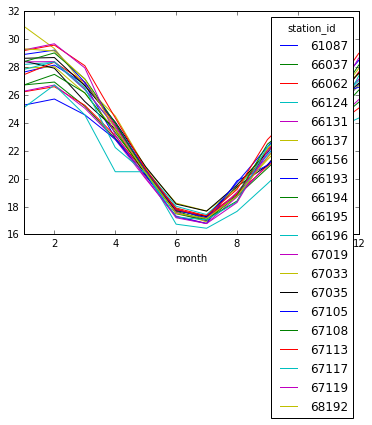

In [19]:
import pandas as pd
tempByStationAndMonthPD = tempByStationAndMonth.toPandas()
tempByStationAndMonthPD.set_index(['month', 'station_id']).unstack()['avg_max_temp'].plot()

In [17]:
import pandas as pd
df = pd.read_csv('data/nsw_temp.csv')

In [18]:
df.groupby('Year')